In [2]:
import numpy as np
import pandas as pd
import warnings
import numpy as np
from itertools import product
from turtle import shape
import pygad
import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.mplot3d import Axes3D
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = ['sans-serif']   
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

data = pd.read_excel('酶复配数据集.xlsx')
data = data.drop_duplicates()

In [3]:
label_encoder = LabelEncoder()
data['酶'] = label_encoder.fit_transform(data['酶'])
data['助剂'] = label_encoder.fit_transform(data['助剂'])

In [4]:
data

酶  助剂   pH     浓度  孵育温度  孵育时间        酶活
0    0   0  7.5  0.002    70    40  0.065300
1    0   0  6.0  0.010    70    40  0.365800
2    0   0  7.5  0.010    70    60  0.408300
3    0   0  7.5  0.100    70    40  0.606200
4    0   0  7.5  0.002    30    40  0.805400
..  ..  ..  ...    ...   ...   ...       ...
205  1   0  9.0  0.010    70    40  0.029822
206  1   3  9.0  0.010    70    40  0.026936
207  1   8  6.0  0.010    70    40  0.036556
208  1   8  9.0  0.010    70    40  0.039923
209  1   9  9.0  0.001    70    40  0.037518

[210 rows x 7 columns]

[0, 0]
[1, 1]
[2, 2]
[3, 3]
[4, 4]
[5, 5]
[6, 6]


<Axes: >

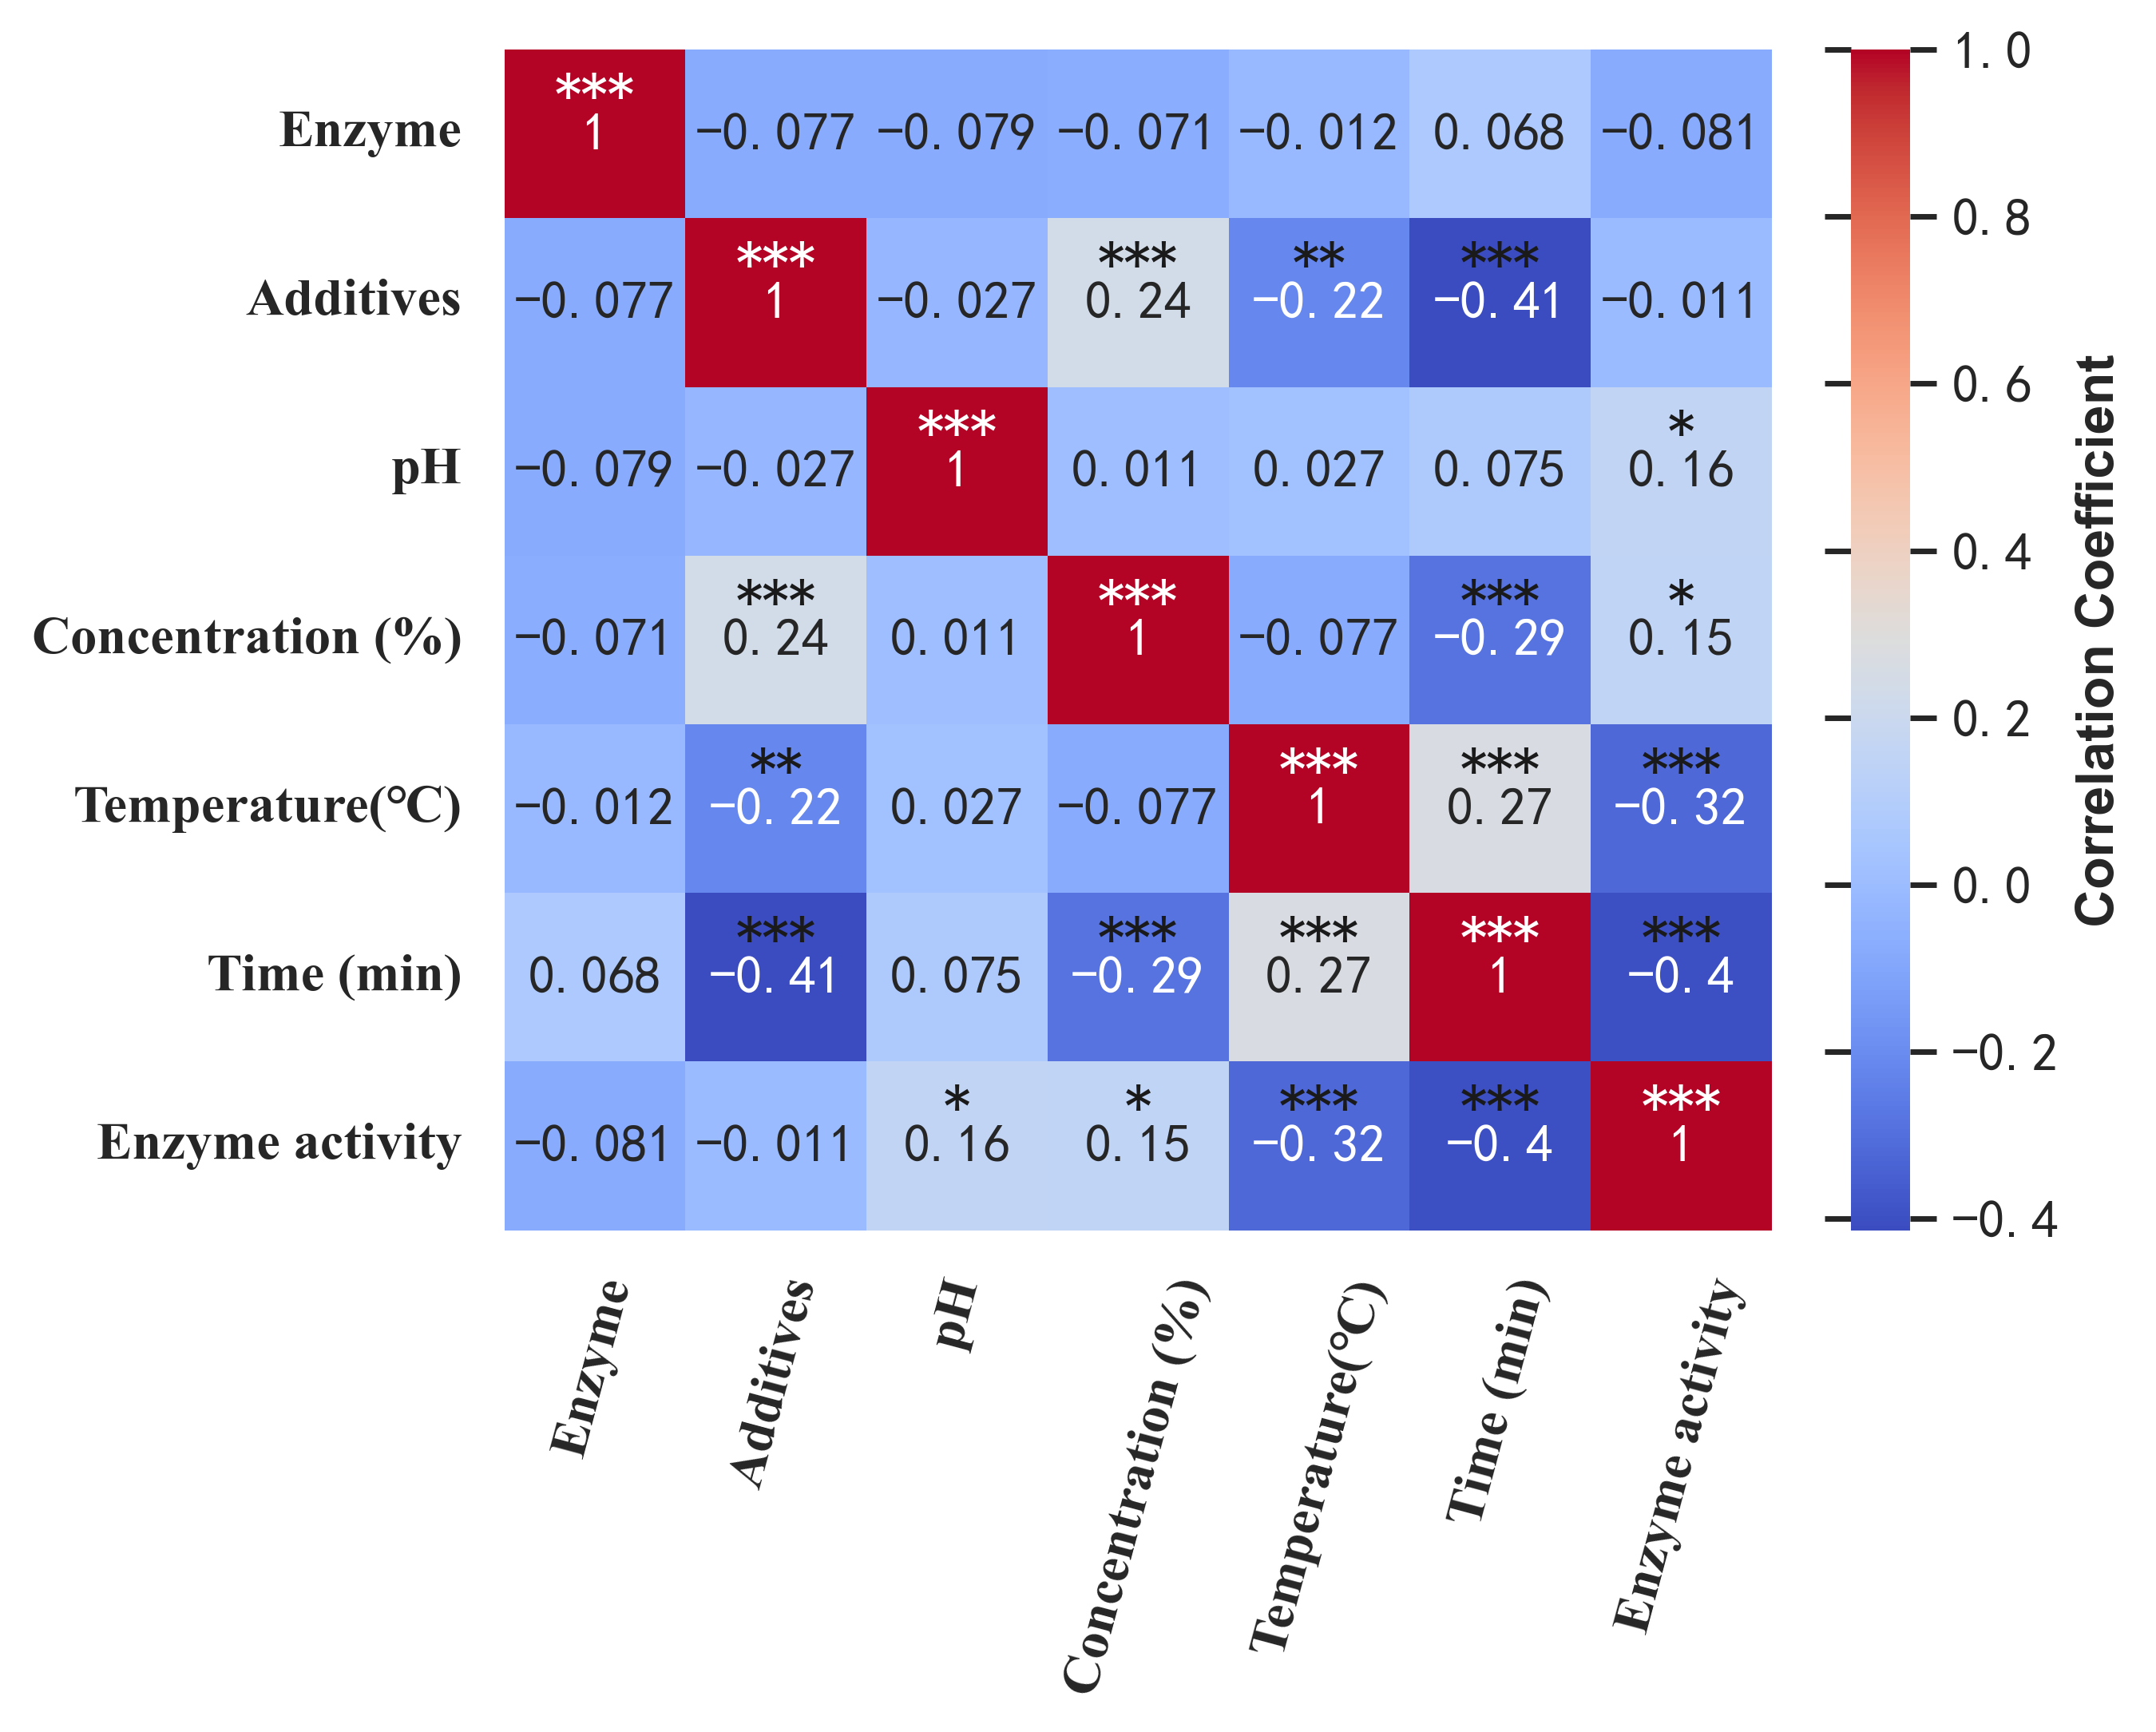

In [5]:
import scipy.stats as stats
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
sns.set(font='SimHei') 
data_2 = pd.read_excel('酶复配数据集.xlsx')
data_2['酶'] = label_encoder.fit_transform(data_2['酶'])
data_2['助剂'] = label_encoder.fit_transform(data_2['助剂'])
data_2 = data_2.rename(columns={'酶': 'Enzyme'})
data_2 = data_2.rename(columns={'助剂':'Additives'})
data_2 = data_2.rename(columns={'浓度':'Concentration (%)'})
data_2 = data_2.rename(columns={'孵育温度':'Temperature(℃)'})
data_2 = data_2.rename(columns={'孵育时间':'Time (min)'})
data_2 = data_2.rename(columns={'酶活':'Enzyme activity'})
features_all2 = data_2.corr()    
plt.figure(dpi=400)

mask = np.zeros_like(features_all2)
mask[np.triu_indices_from(mask)] = False
mask2 = mask
mask = (np.flipud(mask)-1)*(-1)
mask = np.rot90(mask,k = -1)



ax = sns.heatmap(features_all2,cmap = 'coolwarm',annot =True)

rlist = []
plist = []
for i in data_2.columns.values:
    for j in data_2.columns.values:
        r,p = stats.pearsonr(data_2[i],data_2[j])
        rlist.append(r)
        plist.append(p)

rarr = np.asarray(rlist).reshape(len(data_2.columns.values),len(data_2.columns.values))
parr = np.asarray(plist).reshape(len(data_2.columns.values),len(data_2.columns.values))
xlist = ax.get_xticks()
ylist = ax.get_yticks()

widthx = 0
widthy = -0.15

for m in ax.get_xticks():
    for n in ax.get_yticks():
        pv = (parr[int(m),int(n)])
        rv = (rarr[int(m),int(n)])
        if mask2[int(m),int(n)]<1.:
            if abs(rv) > 0.5:
                if  pv< 0.05 and pv>= 0.01:
                    ax.text(n+widthx,m+widthy,'*',ha = 'center',color = 'white')
                if  pv< 0.01 and pv>= 0.001:
                    ax.text(n+widthx,m+widthy,'**',ha = 'center',color = 'white')
                if  pv< 0.001:
                    print([int(m),int(n)])
                    ax.text(n+widthx,m+widthy,'***',ha = 'center',color = 'white')
            else: 
                if  pv< 0.05 and pv>= 0.01:
                    ax.text(n+widthx,m+widthy,'*',ha = 'center',color = 'k')
                elif  pv< 0.01 and pv>= 0.001:
                    ax.text(n+widthx,m+widthy,'**',ha = 'center',color = 'k')
                elif  pv< 0.001:
                    ax.text(n+widthx,m+widthy,'***',ha = 'center',color = 'k')
                    
cbar = ax.collections[0].colorbar  
cbar.set_label('Correlation Coefficient', fontname='Arial',fontweight='bold')  
cbar.ax.tick_params(labelsize=12)    
cbar.ax.yaxis.set_ticks_position('both') 
ax.set_xticklabels(ax.get_xticklabels(), fontfamily='Times New Roman', fontsize=12, fontweight='bold',rotation=75)  
ax.set_yticklabels(ax.get_yticklabels(), fontfamily='Times New Roman', fontsize=12, fontweight='bold', )  
plt.savefig('XGBoost单酶预测热力图.jpg', dpi=600, bbox_inches='tight')
ax

In [7]:
x_ = data.drop(columns=['酶活'], axis=1)
y_ = data['酶活']
scaler = MinMaxScaler()
scaler.fit(x_) 
x_transfer = scaler.transform(x_) 
x_train_,x_test_,y_train_,y_test_ = train_test_split(x_transfer,y_,test_size = 0.2,random_state = 44) 

In [8]:
original_column_names = x_.columns.tolist()
y_test_ = [v for idx, v in enumerate(y_test_, start=0)]  
x_test_restored = scaler.inverse_transform(x_test_)
x_test_restored = pd.DataFrame(x_test_restored)
x_test_restored.columns = original_column_names
x_test_restored.head()

酶   助剂   pH     浓度  孵育温度  孵育时间
0  1.0  0.0  7.5  0.100  50.0  60.0
1  0.0  4.0  7.5  0.500  40.0  10.0
2  1.0  2.0  7.0  0.010  45.0  30.0
3  1.0  3.0  9.0  0.002  50.0  60.0
4  1.0  8.0  7.5  0.100  50.0  60.0

In [16]:
xgb_ = xgb.XGBRegressor()
param_grid = {  
    "n_estimators": [50, 100, 200],  
    "learning_rate": [0.01, 0.05, 0.1],  
    "max_depth": [3, 5, 7],  
    "colsample_bytree": [0.5, 0.7],  
    "gamma": [0, 0.25, 1.0]  
} 
xgb_model_ = GridSearchCV(estimator=xgb_, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')
xgb_model_.fit(x_train_, y_train_)
print('XGBoost模型的最佳验证参数：\n',xgb_model_.best_params_)
xgb_model_ = xgb_model_.best_estimator_ 

XGBoost模型的最佳验证参数：
 {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [13]:
from sklearn.model_selection import cross_val_score
param1_range = np.array([1,2,3,4,5,6]) 
param2_range = np.array([100,200,300 ])  
param1_grid, param2_grid = np.meshgrid(param1_range, param2_range)
scores = np.zeros((param1_range.size, param2_range.size))
for i in range(param1_range.size):
    for j in range(param2_range.size):
        param1 = param1_range[i]
        param2 = param2_range[j]
        
        xgb_ = xgb.XGBRegressor(max_depth=param1,n_estimators=param2)
        
      
        score = np.mean(cross_val_score(xgb_, x_train_, y_train_, cv=5))
        scores[i, j] = score
import plotly.graph_objects as go
param1_grid = np.array([1,2,3,4,5,6])  
param2_grid = np.array([100,200,300 ]) 
fig = go.Figure(data =
    go.Contour(x=param1_grid, y=param2_grid, z=scores
    ))
fig.update_xaxes(title_text="max_depth")
fig.update_yaxes(title_text="n_estimators")
fig.show()

In [17]:
pre1 = xgb_model_.predict(x_train_)
pre2 = xgb_model_.predict(x_test_)
R2_1 = r2_score(y_train_,pre1)
R2_2 = r2_score(y_test_,pre2)
print("train_model's R2: {:.4f}".format(R2_1))
print("test_model's R2: {:.4f}".format(R2_2))
mse_train_ = np.mean(np.power(y_train_ - pre1, 2))
mse_test_ = np.mean(np.power(y_test_ - pre2, 2))
print("train_model's MSE: {:.4f}".format(mse_train_))
print("test_model's MSE: {:.4f}".format(mse_test_))
print("train_model's RMSE:",np.sqrt(metrics.mean_squared_error(y_train_,pre1)))
print("test_model's RMSE:",np.sqrt(metrics.mean_squared_error(y_test_,pre2)))

train_model's R2: 0.9973
test_model's R2: 0.7816
train_model's MSE: 0.0004
test_model's MSE: 0.0246
train_model's RMSE: 0.01891934863032433
test_model's RMSE: 0.1568256271952341


In [18]:
pre_result = x_test_restored.copy() 
pre_result['实际酶活'] = y_test_
pre_result['预测酶活'] = pre2

In [19]:
pre_result

酶   助剂   pH      浓度  孵育温度  孵育时间      实际酶活      预测酶活
0   1.0  0.0  7.5  0.1000  50.0  60.0  0.377298  0.383420
1   0.0  4.0  7.5  0.5000  40.0  10.0  1.049666  1.016384
2   1.0  2.0  7.0  0.0100  45.0  30.0  0.585408  0.310130
3   1.0  3.0  9.0  0.0020  50.0  60.0  0.042739  0.095939
4   1.0  8.0  7.5  0.1000  50.0  60.0  0.345588  0.396180
5   1.0  8.0  6.0  0.1000  50.0  20.0  0.641085  0.559017
6   1.0  9.0  6.0  0.0002  50.0  40.0  0.618852  0.478516
7   2.0  6.0  7.5  0.5000  40.0  10.0  1.040000  1.031224
8   0.0  3.0  7.0  0.0100  60.0  30.0  1.027062  0.840918
9   0.0  2.0  9.0  0.0100  60.0  30.0  1.124441  1.379294
10  0.0  6.0  7.5  0.0100  40.0  10.0  1.027143  1.042955
11  0.0  0.0  9.0  0.0100  30.0  40.0  0.903700  0.925630
12  0.0  3.0  7.5  0.5000  40.0  10.0  1.078528  1.005986
13  0.0  0.0  7.5  0.1000  70.0  40.0  0.606200  0.447830
14  2.0  0.0  7.5  0.0100  70.0  20.0  0.846690  0.736938
15  2.0  6.0  7.5  0.0001  40.0  10.0  1.010000  1.021057
16  1.0  9.0  6.0  0.0100  50.0  20.0  0.731158  0.407863
17  2.0  1.0  9.0  0.0100  50.0  40.0  0.947277  0.978412
18  0.0  3.0  7.5  0.1000  40.0  10.0  1.046857  0.998328
19  2.0  0.0  7.5  0.1000  30.0  40.0  0.814043  0.801080
20  2.0  1.0  9.0  0.0010  70.0  40.0  0.856821  0.788487
21  0.0  0.0  7.5  0.0020  50.0  60.0  0.981000  0.753680
22  0.0  6.0  7.5  0.1000  40.0  10.0  1.023727  1.035811
23  1.0  0.0  7.5  0.1000  30.0  40.0  0.353670  0.321521
24  2.0  1.0  6.0  0.0100  50.0  40.0  0.689000  0.415637
25  0.0  4.0  9.0  1.0000  60.0  30.0  1.212657  0.787513
26  0.0  7.0  7.5  0.0100  40.0  10.0  1.042674  1.028588
27  1.0  9.0  9.0  0.0002  50.0  60.0  0.043658  0.136412
28  0.0  4.0  7.5  0.0001  40.0  10.0  1.009617  1.007797
29  0.0  0.0  9.0  0.0100  50.0  60.0  1.142500  0.893147
30  2.0  5.0  7.5  0.5000  40.0  10.0  1.020000  1.039020
31  2.0  3.0  7.5  0.0001  40.0  10.0  1.030000  1.066458
32  2.0  4.0  7.5  0.5000  40.0  10.0  1.050000  1.031654
33  2.0  1.0  6.0  0.0010  70.0  40.0  0.142889  0.426341
34  0.0  2.0  9.0  0.0002  45.0  30.0  1.230079  1.359601
35  0.0  3.0  9.0  0.0020  45.0  30.0  0.899299  0.854572
36  0.0  2.0  7.0  0.0002  30.0  30.0  1.354396  1.221264
37  0.0  1.0  7.5  0.0002  70.0  40.0  0.787800  0.649017
38  0.0  8.0  7.5  0.1000  40.0  10.0  1.047031  1.039923
39  1.0  2.0  9.0  0.0010  30.0  30.0  0.593180  0.979754
40  1.0  8.0  9.0  0.1000  50.0  40.0  0.009221  0.049710
41  0.0  1.0  7.5  0.0002  50.0  20.0  0.830600  0.823994

In [20]:
data_seaborn = pd.DataFrame()
data_seaborn['enzyme activity_true'] = y_test_
data_seaborn['enzyme activity_pred'] = pre2

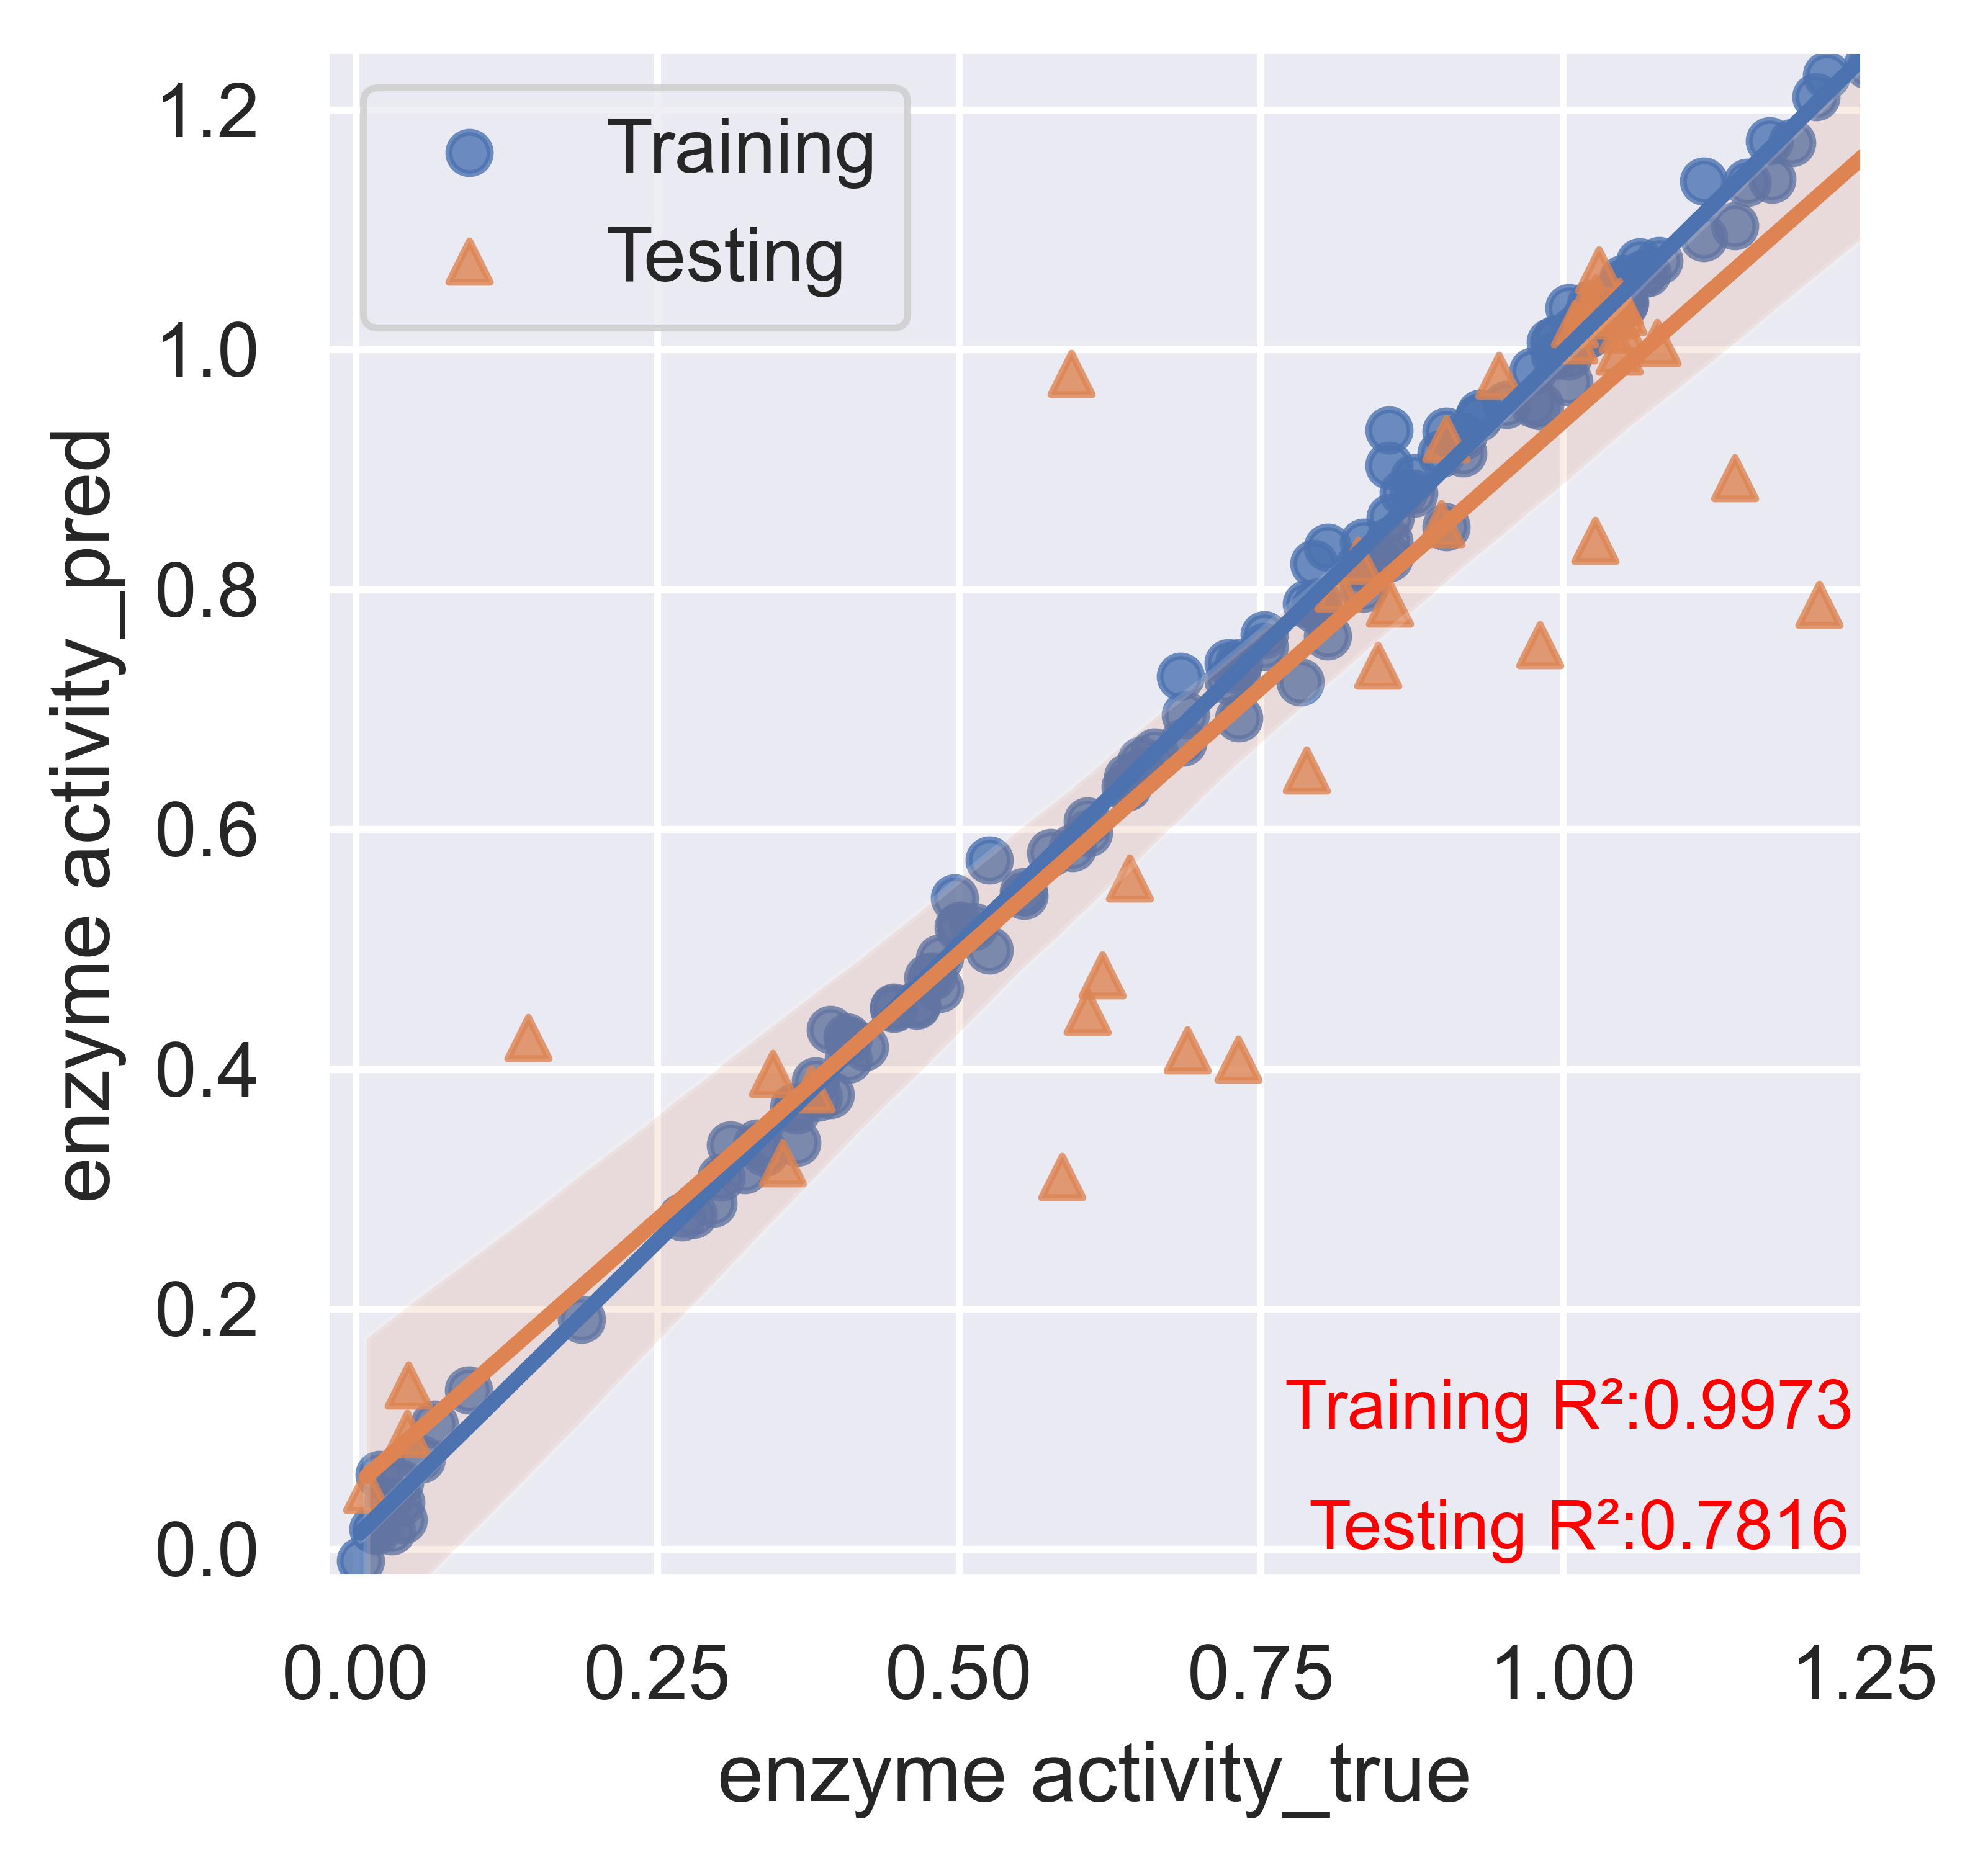

In [27]:
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False 

plt.figure(dpi=800, figsize=(4,4))
sns.set(font='SimHei')
sns.set(color_codes=True)

sns.regplot(x=y_train_,y=pre1, label='Training')
plt.legend(loc='upper left')

sns.regplot(x=y_test_,y=pre2,marker='^', label='Testing')
plt.legend(loc='upper left')

plt.xlim([-0.025, 1.25])   
plt.ylim([-0.025, 1.25]) 

plt.text(0.77, 0.1, 'Training R²:0.9973', fontsize=10, color='red')   
plt.text(0.79, 0, 'Testing R²:0.7816', fontsize=10, color='red')   
plt.xlabel('enzyme activity_true')  
plt.ylabel('enzyme activity_pred') 

plt.savefig('XGBoost单酶预测线性回归图.jpg', dpi=600, bbox_inches='tight')